# Quickly Simulate an RBC Model

Here I demonstrate how how relatively straightforward it is to appoximate, solve, and simulate a DSGE model using `linearsolve`. In the example that follows, I describe the procedure more carefully.

\begin{align}
C_t^{-\sigma} & = \beta E_t \left[C_{t+1}^{-\sigma}(\alpha A_{t+1} K_{t+1}^{\alpha-1} + 1 - \delta)\right]\\
C_t + K_{t+1} & = A_t K_t^{\alpha} + (1-\delta)K_t\\
\log A_{t+1} & = \rho_a \log A_{t} + \epsilon_{t+1}
\end{align}

In the block of code that immediately follows, I input the model, solve for the steady state, compute the linear approximation of the equilibirum conditions, and compute some impulse responses following a 1 percent shock to technology $A_t$.

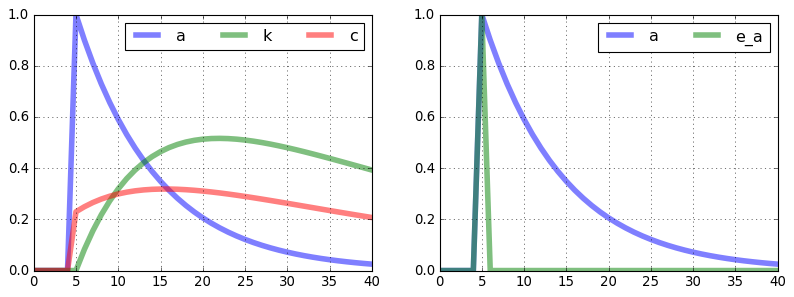

In [1]:
# Import numpy, pandas, linearsolve, matplotlib.pyplot
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

# Input model parameters
parameters = pd.Series(dtype=float)
parameters['alpha'] = .35
parameters['beta'] = 0.99
parameters['delta'] = 0.025
parameters['rhoa'] = .9
parameters['sigma'] = 1.5
parameters['A'] = 1

# Funtion that evaluates the equilibrium conditions
def equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
    
    # Household Euler equation
    euler_eqn = p.beta*fwd.c**-p.sigma*(p.alpha*fwd.a*fwd.k**(p.alpha-1)+1-p.delta) - cur.c**-p.sigma
    
    # Goods market clearing
    market_clearing = cur.c + fwd.k - (1-p.delta)*cur.k - cur.a*cur.k**p.alpha
        
    # Exogenous technology
    technology_proc = p.rhoa*np.log(cur.a) - np.log(fwd.a)
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            euler_eqn,
            market_clearing,
            technology_proc
        ])

# Initialize the model
model = ls.model(equations = equations,
                 n_states=2,
                 n_exo_states = 1,
                 variables=['a','k','c'],
                 parameters = parameters)

# Compute the steady state numerically
guess = [1,1,1]
model.compute_ss(guess)

# Find the linear approximation around the non-stochastic steady state and solve
model.approximate_and_solve()

# Compute impulse responses and plot
model.impulse(T=41,t0=5,shocks=[0.01])

fig = plt.figure(figsize=(12,4))
ax1 =fig.add_subplot(1,2,1)
(model.irs['e_a'][['a','k','c']]*100).plot(lw='5',alpha=0.5,grid=True,ax=ax1).legend(loc='upper right',ncol=3)
ax2 =fig.add_subplot(1,2,2)
(model.irs['e_a'][['a','e_a']]*100).plot(lw='5',alpha=0.5,grid=True,ax=ax2).legend(loc='upper right',ncol=2);